### STATS 202 
Waseh Ahmad
Summer 2019

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [90]:
#import statements
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import random
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,LeaveOneOut,cross_validate, GridSearchCV
from sklearn import linear_model, kernel_ridge
from statsmodels.graphics.gofplots import ProbPlot
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize, scale, PolynomialFeatures
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE 


import library

warnings.filterwarnings('ignore')

In [3]:
#load data
files = ['Study_A.csv','Study_B.csv','Study_C.csv','Study_D.csv','Study_E.csv']
trials = []
for file in files:
    trials.append(pd.read_csv(file))
testDF = pd.read_csv('Study_E.csv')
trialsDF = pd.concat(trials)
# trialsDF.PatientID = pd.factorize(trialsDF.PatientID)[0]
# trialsDF.Country = pd.factorize(trialsDF.Country)[0]

# trialsDF.corr().style.background_gradient(cmap='coolwarm')
# plt.scatter(trialsDF.PatientID,trialsDF.SiteID)

In [4]:
#add constant term
trialsDF = sm.add_constant(trialsDF)
#creat a dataframe sorted by patient id and by visit day
sortedDF = trialsDF.sort_values(['PatientID', 'VisitDay'], ascending=[True, True])
# reset the index for the different trials
sortedDF = sortedDF.reset_index()

def GetLaggedDiff(df,resultColumn,varColumn):
    currId = prevId = -1
    prevRow = []
    visitDay = 0;
    for index,row in df.iterrows():
        currId = int(row['PatientID'])
        if(currId != prevId):
            df.at[index,resultColumn] = 0
            df.at[index,'VisitDay'] = 0
            visitDay=0;
        else:
            visitDay +=1
            df.at[index,'PANSS_Lag1'] = prevRow[varColumn]
            df.at[index,'VisitDay'] = visitDay
            df.at[index,resultColumn] = row[varColumn] - prevRow[varColumn]
        prevRow = row
        prevId = currId
    return df

df= sortedDF
df['Ps'] = sortedDF.P1 + sortedDF.P2 + sortedDF.P3+ sortedDF.P4+ sortedDF.P5+ sortedDF.P6+ sortedDF.P7
df['Ns'] = sortedDF.N1 + sortedDF.N2 + sortedDF.N3+ sortedDF.N4+ sortedDF.N5+ sortedDF.N6+ sortedDF.N7
df['Gs'] = sortedDF.G1 + sortedDF.G2 + sortedDF.G3+ sortedDF.G4+ sortedDF.G5+ sortedDF.G6+ sortedDF.G7 + sortedDF.G8 + sortedDF.G9 + sortedDF.G10+ sortedDF.G11+ sortedDF.G12+ sortedDF.G13+ sortedDF.G14 + sortedDF.G15 +sortedDF.G16 

sortedDF = GetLaggedDiff(sortedDF,'PANSS_Total_diff','PANSS_Total')
prunedDF = sortedDF.loc[sortedDF['LeadStatus'] == 'Passed']

In [5]:
groupedDF = pd.DataFrame({'TxGroup':sortedDF.groupby('PatientID').TxGroup.agg(pd.Series.mode),'PANSS_diff_avg':sortedDF.groupby('PatientID').mean().PANSS_Total_diff})
formula = "PANSS_diff_avg~ C(TxGroup)"
olsModelDiff = smf.ols(formula,data=groupedDF).fit()
olsModelDiff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PANSS_diff_avg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1818
Date:                Sun, 04 Aug 2019   Prob (F-statistic):              0.670
Time:                        12:52:37   Log-Likelihood:                -6955.7
No. Observations:                2947   AIC:                         1.392e+04
Df Residuals:                    2945   BIC:                         1.393e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.6928      0.066    -25.567      0.000      -1.823      -1.563
C(TxGroup)[T.Treatment]    -0.0403      0.094     -0.426      0.670      -0.226       0.145
==============================================================================
Omnibus:                      454.369   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6892.492
Skew:                          -0.174   Prob(JB):                         0.00
Kurtosis:                      10.484   Cond. No.                         2.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Patient Segmentation

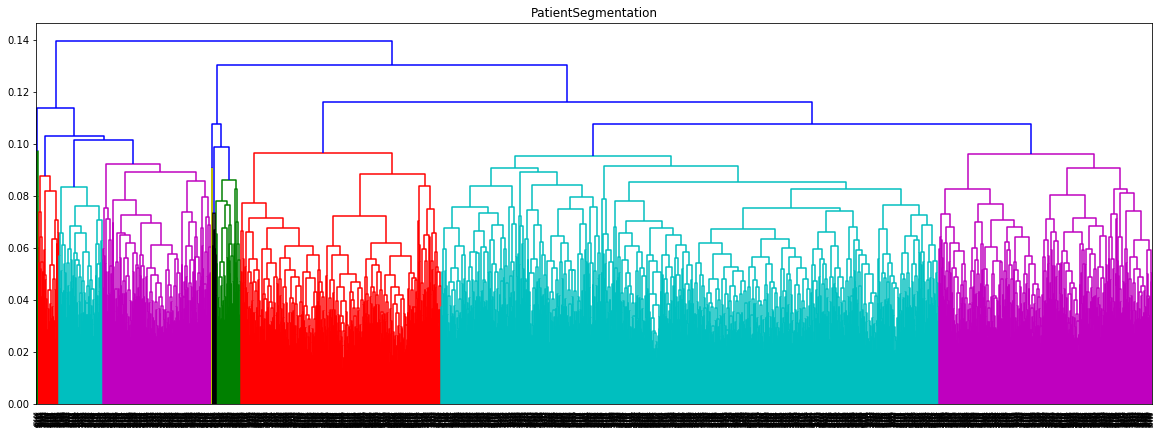

In [6]:
firstVisits = sortedDF.groupby('PatientID').first().drop(['index','const','Study','TxGroup','SiteID','RaterID','AssessmentiD','LeadStatus','Country','VisitDay','PANSS_Total_diff','PANSS_Lag1'],axis = 1)
# normalize the data and create a df out of it
data_scaled = normalize(firstVisits,axis=0)
data_scaled = pd.DataFrame(data_scaled, columns=firstVisits.columns)


labels = firstVisits.index.values
linked = hierarchy.linkage(data_scaled, 'complete',metric='euclidean')

plt.figure(figsize=(20, 7))  
arrestsDendrogram = hierarchy.dendrogram(linked,labels=labels)
plt.title("PatientSegmentation")
plt.axhline(y=0.3, color='r', linestyle='--')
plt.show() 


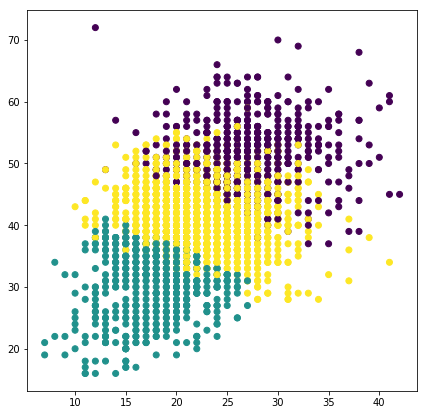

In [7]:
numClusters = 3
cluster = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='complete')  
clusters = cluster.fit_predict(firstVisits)
firstVisits['Segment'] = clusters
plt.figure(figsize=(7, 7))  
# for seg in range(4):
#     (firstVisits.loc[firstVisits['Segment'] == seg].boxplot(column=['Ps'],by=['Segment']))
plt.scatter(firstVisits['Ns'], firstVisits['Gs'], c=cluster.labels_) 
# data_scaled

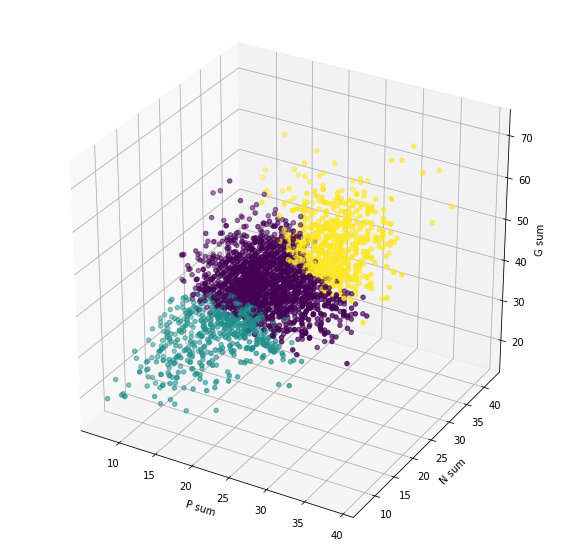

In [8]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=cluster.labels_, cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()


In [9]:
centers = []
for k in np.unique(clusters):
    #for each parameter
    kthMeans = []
    for p in firstVisits.drop(['Segment'],axis=1).columns:
        #compute mean
        kthMeans.append(np.mean(firstVisits[p].loc[firstVisits['Segment'] == k]))
    centers.append(np.asarray(kthMeans))
kMeansClusters = KMeans(n_clusters=numClusters,init=np.asarray(centers),random_state=1).fit(firstVisits.drop(['Segment'],axis=1))

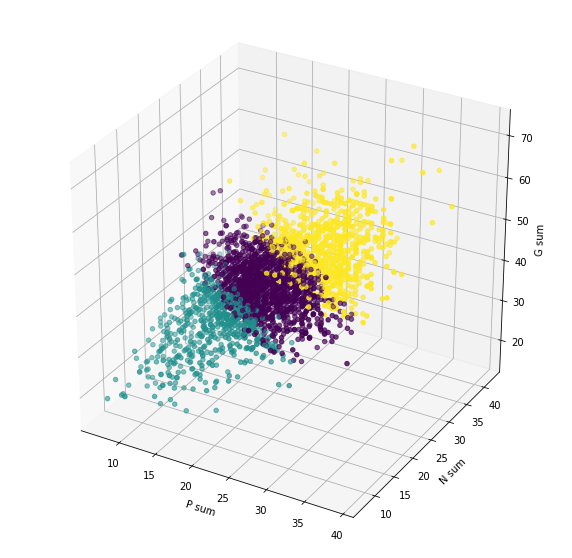

In [10]:
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=kMeansClusters.labels_,cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()

# Forecasting

In [40]:
idsToForecast = pd.read_csv("sample_submission_PANSS.csv").PatientID

#divide set into training and test data
sortedDF.loc[sortedDF['LeadStatus'] == 'Passed']
initialDF = sortedDF[['PANSS_Total','Study','TxGroup','VisitDay','PANSS_Lag1','PatientID']]

xSet = initialDF.loc[sortedDF.VisitDay != 0].drop(['PANSS_Total','PatientID'],axis=1)
ySet = initialDF.loc[sortedDF.VisitDay != 0].PANSS_Total
xTrain, xTest, yTrain, yTest = train_test_split(xSet, ySet, test_size=0.25, random_state=123456)
trainDF = pd.concat([xTrain,yTrain],axis=1)

In [41]:

xVariables = 'C(Study) + C(TxGroup)*VisitDay + VisitDay + PANSS_Lag1'
factorVars = ['TxGroup','Study']
formula = 'PANSS_Total ~'+xVariables

modelFit = smf.ols(formula,data=trainDF).fit()
#Test MSE
yPred = modelFit.predict(xTest)
print(library.GetMSE(yPred,yTest))
#training MSE
yPredTrainOLS = modelFit.predict(xTrain)
print(library.GetMSE(yPredTrainOLS,yTrain))


52.030358886694756
52.54937077218131


In [ ]:

#make the prediction by first making the df for the features being used
inputDF = initialDF.loc[initialDF.PatientID.isin(idsToForecast)]
# groupedDF = pd.DataFrame({'TxGroup':sortedDF.groupby('PatientID').TxGroup.agg(pd.Series.mode),'PANSS_diff_avg':sortedDF.groupby('PatientID').mean().PANSS_Total_diff})
inputDF = inputDF.groupby('PatientID').last()
inputDF.PANSS_Lag1 = inputDF.PANSS_Total 
inputDF = inputDF.drop(['PANSS_Total'],axis=1)

In [42]:

yPred = modelFit.predict(inputDF)

submission = pd.DataFrame(yPred)
# submission.to_csv("forecast_submit.csv")

yPredLasso = lassoModelFit.predict(library.InjectFactors(inputDF,factorVars))
submission = pd.DataFrame(yPredLasso)
submission['PatientID'] = idsToForecast
# submission.to_csv("forecast_submit_Lasso.csv",header=['PatientID','PANSS_Total'])

In [129]:
# Bagging approach
#generate polynomials and transforms of the features
# do bagging, by first selecting the features using forward step-wise, and then, fitting the model on it

np.random.seed(5)
baggingModel = Pipeline([
  ('transformation', PolynomialFeatures()),
  ('feature_selection', RFE(linear_model.LinearRegression())),
  ('regression', BaggingRegressor(base_estimator=linear_model.LinearRegression()))
])
# baggingModelFit = baggingModel.fit(library.InjectFactors(xTrain,factorVars),yTrain)
#run CV on pipeline
# scores = cross_validate(baggingModel, PolynomialFeatures(4).fit_transform(library.InjectFactors(xTrain,factorVars)),yTrain, cv=5,scoring='neg_mean_squared_error',return_estimator=True)
parameters = {'feature_selection__n_features_to_select':[1,2,4,8,16,32], 'transformation__degree':[1,2,3]}

#uncomment the followign line to run the tuning
# tuneOutput = GridSearchCV(baggingModel, parameters, scoring='neg_mean_squared_error', cv=4).fit(library.InjectFactors(xTrain,factorVars),yTrain)

Features To select:8
Number of Polynomials:1


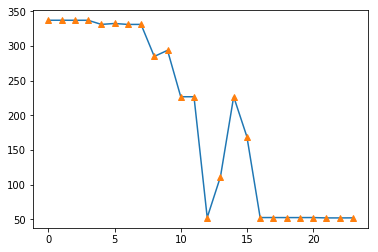

In [139]:
results = pd.DataFrame(tuneOutput.cv_results_)
results
plt.plot(range(len(results)),np.abs(results.mean_test_score))
plt.errorbar(range(len(results)),np.abs(results.mean_test_score),linestyle='None', marker='^')
print("Features To select:"+str(results.iloc[12].param_feature_selection__n_features_to_select))
print("Number of Polynomials:"+str(results.iloc[12].param_transformation__degree))

In [146]:
baggingModel.set_params(feature_selection__n_features_to_select=8, transformation__degree=1)
baggingModelFit = baggingModel.fit(library.InjectFactors(xTrain,factorVars),yTrain)  
yPredTrain = baggingModelFit.predict(library.InjectFactors(xTrain,factorVars))
yPredTest = baggingModelFit.predict(library.InjectFactors(xTest,factorVars))
print("Train MSE:"+str(library.GetMSE(yPredTrain,yTrain)))
print("Test MSE:"+str(library.GetMSE(yPredTest,yTest)))

Train MSE:52.55984373115498
Test MSE:52.05913383207837


In [37]:
#create a set of predictions
baggingModelFit = baggingModel.fit(PolynomialFeatures(4).fit_transform(library.InjectFactors(xTrain,factorVars)),yTrain)
predictions = baggingModelFit.predict(PolynomialFeatures(4).fit_transform(library.InjectFactors(inputDF,factorVars)))

In [ ]:
submission = pd.DataFrame(predictions)
submission['PatientID'] = idsToForecast
submission.to_csv("forecast_submit_Bagging.csv",header=['PatientID','PANSS_Total'])

In [153]:
# boosting approach
import xgboost as xgb




max_depth = 3
min_child_weight = 10
subsample = 0.5
colsample_bytree = 0.6
objective = 'reg:squarederror'
num_estimators = 1000
learning_rate = 0.3

boostModel = xgb.XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate)

eval_set = [(library.InjectFactors(xTrain,factorVars), yTrain), (library.InjectFactors(xTest,factorVars), yTest)]
xgbModelFit = boostModel.fit(library.InjectFactors(xTrain,factorVars), yTrain, eval_set=eval_set, verbose=False)



In [172]:
yPredTrain = xgbModelFit.predict(library.InjectFactors(xTrain,factorVars))
yPredTest = xgbModelFit.predict(library.InjectFactors(xTest,factorVars))

print("Train MSE:"+str(library.GetMSE(yPredTrain,yTrain)))
print("Test MSE:"+str(library.GetMSE(yPredTest,yTest)))

inputDFWithCategories = library.InjectFactors(inputDF,factorVars)
inputDFWithCategories['B'] = np.zeros(len(inputDF))
inputDFWithCategories['C'] = np.zeros(len(inputDF))
inputDFWithCategories['D'] = np.zeros(len(inputDF))
inputDFWithCategories['E'] = np.ones(len(inputDF))


predictions = xgbModelFit.predict(inputDFWithCategories)
submission = pd.DataFrame(predictions)
submission['PatientID'] = idsToForecast
# submission.to_csv("forecast_submit_XGB.csv",header=['PANSS_Total','PatientID'])

Train MSE:46.23509618595952
Test MSE:49.96744845477244


,0,PatientID
0,74.823067,50002
1,70.949371,50003
2,60.351616,50004
3,58.221615,50006
4,42.528214,50007
5,56.026608,50008
6,45.426762,50009
7,50.642361,50012
8,63.666023,50013
9,83.322731,50015


### References
1.https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
